In [1]:
PRETRAINED = True
DOWNSAMPLE = False

In [2]:
!pip install -q tensorflow_text
!pip install -q tf-models-official==2.11.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
distributed 20

In [3]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text  # Registers the ops.
from keras.utils import to_categorical
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_train = pd.read_csv('/kaggle/input/labeled-unreliable-news-lun/fulltrain.csv', encoding='utf-8', names=['label', 'text'])
df_test = pd.read_csv('/kaggle/input/labeled-unreliable-news-lun/balancedtest.csv', encoding='utf-8', names=['label', 'text'])

In [5]:
TEXT_LABELS = {1: 'Satire', 2: 'Hoax', 3: 'Propaganda', 4: 'Reliable News'}
df_train['label'] = [TEXT_LABELS[x] for x in df_train['label']]
df_test['label'] = [TEXT_LABELS[x] for x in df_test['label']]

In [6]:
df_train.head()

,label,text
0,Satire,"A little less than a decade ago, hockey fans w..."
1,Satire,The writers of the HBO series The Sopranos too...
2,Satire,Despite claims from the TV news outlet to offe...
3,Satire,After receiving 'subpar' service and experienc...
4,Satire,After watching his beloved Seattle Mariners pr...


In [7]:
df_test.head()

,label,text
0,Satire,When so many actors seem content to churn out ...
1,Satire,In what football insiders are calling an unex...
2,Satire,In a freak accident following Game 3 of the N....
3,Satire,North Koreas official news agency announced to...
4,Satire,The former Alaska Governor Sarah Palin would b...


In [8]:
DOWNSAMPLE_RATIO = 0.01

# Use stratify sampling to preserve the original class distribution
if DOWNSAMPLE:
    df_train, _ = train_test_split(df_train, train_size=DOWNSAMPLE_RATIO, random_state=42, stratify=df_train['label'])
    df_test, _ = train_test_split(df_test, train_size=DOWNSAMPLE_RATIO, random_state=42, stratify=df_test['label'])

In [9]:
print('Shape of the training data: ', df_train.shape)
print('Shape of the test data: ', df_test.shape)

Shape of the training data:  (48854, 2)
Shape of the test data:  (3000, 2)


In [10]:
# Check the class distribution
df_train.groupby('label').count()

,text
label,
Hoax,6942
Propaganda,17870
Reliable News,9995
Satire,14047


In [11]:
# Check the class distribution
df_test.groupby('label').count()

,text
label,
Hoax,750
Propaganda,750
Reliable News,750
Satire,750


## Encode the classes

In [12]:
le = LabelEncoder()

X_train = df_train['text']
y_train = le.fit_transform(df_train['label'])

X_test = df_test['text']
y_test = le.transform(df_test['label'])

## Random Oversampling

In [13]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

In [14]:
from collections import Counter
print(X_train.shape, y_train.shape)
print(sorted(Counter(y_train).items()))

(71480, 1) (71480,)
[(0, 17870), (1, 17870), (2, 17870), (3, 17870)]


### Convert to one-hot vectors

In [15]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [16]:
print(y_train.shape, y_test.shape)

(71480, 4) (3000, 4)


## Split validation set for hyperparameter tuning

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, stratify=y_train)

## BERT Model

In [18]:
def build_model(num_classes, optimizer, max_seq_length=128):
    
    
    preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

    # Step 1: tokenize batches of text inputs.
    text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
    tokenize = hub.KerasLayer(preprocessor.tokenize)
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]

    # Step 2 (optional): modify tokenized inputs.
    pass

    # Step 3: pack input sequences for the Transformer encoder.
    seq_length = max_seq_length
    bert_pack_inputs = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length))  # Optional argument.
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
         
    encoder = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-8-h-768-a-12/versions/2",
                             trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    out = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
    
    
    model = tf.keras.models.Model(text_inputs, out)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes, average='macro')])
    
    return model

In [19]:
def plot_loss(history):
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.tight_layout()

In [20]:
# Define the optimizer which uses the same learning rate schedule as BERT pre-training
epochs = 10
batch_size = 32
eval_batch_size = 32

train_data_size = len(X_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw') # by default, 0.01 weight_decay is already included.

model = build_model(num_classes=len(TEXT_LABELS), optimizer=optimizer, max_seq_length=512)
model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint('bert-weights', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['keras_layer[0][0]']            
                                (None, 512),                                                      
                                 'input_type_ids':                                                
                                (None, 512),                                                  

In [21]:
!nvidia-smi

Sun Mar 26 12:21:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |  15781MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
if PRETRAINED:
    model.load_weights("/kaggle/input/labeled-unreliable-news-lun/bert-weights")
else:    
    history = model.fit(x=X_train,
              y=y_train,
              validation_data=(X_val, y_val),
              epochs=epochs, 
              callbacks=[checkpoint, early_stopping], 
              batch_size=batch_size,
              validation_batch_size=eval_batch_size,
              verbose=1)

    plot_loss(history)

## Evaluation

In [23]:
X_test = df_test['text']
y_test = le.transform(df_test['label'])

In [24]:
y_proba = model.predict(X_test, batch_size=eval_batch_size)
y_pred = np.argmax(y_proba, axis=1)
y_pred_labels = le.inverse_transform(y_pred)
y_true_labels = le.inverse_transform(y_test)

94/94 [==============================] - 53s 538ms/step


In [25]:
print(classification_report(y_true=y_true_labels, y_pred=y_pred_labels))

               precision    recall  f1-score   support

         Hoax       0.52      0.37      0.44       750
   Propaganda       0.44      0.52      0.48       750
Reliable News       0.66      0.88      0.75       750
       Satire       0.74      0.55      0.63       750

     accuracy                           0.58      3000
    macro avg       0.59      0.58      0.57      3000
 weighted avg       0.59      0.58      0.57      3000



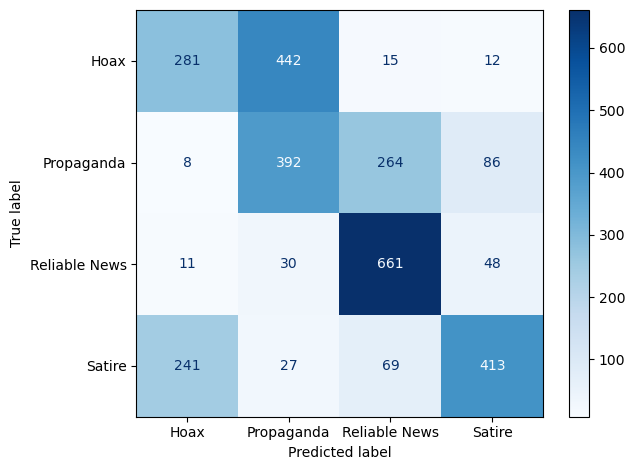

In [26]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.tight_layout()

### Incorrect Examples

In [27]:
df_test['predicted'] = y_pred_labels

for i, (true, pred) in enumerate([
    ('Hoax', 'Propaganda'), 
    ('Propaganda', 'Reliable News'),
    ('Propaganda', 'Satire'), 
    ('Satire', 'Hoax')]):
    
    print(f"({i+1}): {true} but predicted as {pred}:")
    print("-"*20)
    print(df_test[(df_test['label'] == true) & (df_test['predicted'] == pred)].iloc[0]['text'][:1000])
    print("-"*20)
    print()

(1): Hoax but predicted as Propaganda:
--------------------
Ferguson Protesters Take Advantage Of Cop-Involved Shooting In South St. Louis With Unrest Here we go again. We in St. Louis are getting really tired of this. Last evening at about 7:30 in the Shaw Neighborhood of the City of St. Louis, so named for being the area around the Missouri Botanical Garden or Shaws Garden, an off-duty St. Louis City cop who was working a second shift or security for a private firm with permission, shot and killed a suspect who physically threatened him according to reports. A simple narrative of the incident is posted on the KMOV website, the local CBS television affiliate: Authorities said the shooting occurred in the 4100 block of Shaw around 7:30 p.m. According to police, an off-duty police officer was patrolling for a private security company in the Shaw neighborhood. As he drove by the intersection of Klemm and Shaw, he noticed three men. Police said the men started to run and the officer chase

## Evaluation on COVID dataset

In [28]:
df_covid = pd.read_csv('/kaggle/input/covid-unreliable-news/covid_unreliable_news_cleaned.csv', encoding='utf-8')

y_covid_test = le.transform(df_covid['class'])
X_covid_test = df_covid['content_text']

y_covid_proba = model.predict(X_covid_test, batch_size=eval_batch_size)
y_covid_pred = np.argmax(y_covid_proba, axis=1)
y_covid_pred_labels = le.inverse_transform(y_covid_pred)
y_covid_true_labels = le.inverse_transform(y_covid_test)

print(classification_report(y_true=y_covid_true_labels, y_pred=y_covid_pred_labels))

4/4 [==============================] - 2s 529ms/step
               precision    recall  f1-score   support

         Hoax       0.60      0.10      0.17        30
   Propaganda       0.34      0.59      0.43        29
Reliable News       0.41      0.40      0.41        30
       Satire       0.86      1.00      0.93        31

     accuracy                           0.53       120
    macro avg       0.55      0.52      0.48       120
 weighted avg       0.56      0.53      0.49       120



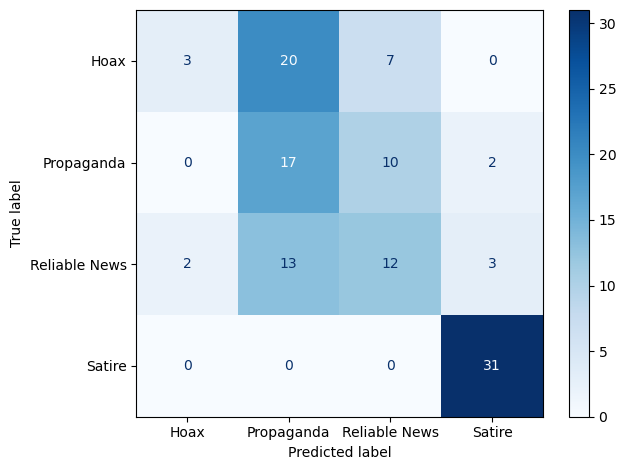

In [29]:
cm = confusion_matrix(y_covid_true_labels, y_covid_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.tight_layout()

In [30]:
df_covid['predicted'] = y_covid_pred_labels
for i, (true, pred) in enumerate([
    ('Hoax', 'Propaganda'), 
    ('Propaganda', 'Reliable News'),
    ('Reliable News', 'Propaganda')]):
    
    print(f"({i+1}): {true} but predicted as {pred}:")
    print("-"*20)
    print(df_covid[(df_covid['class'] == true) & (df_covid['predicted'] == pred)].iloc[0]['content_text'][:1000])
    print("-"*20)
    print()

(1): Hoax but predicted as Propaganda:
--------------------
 Is 5G to partially blame for coronavirus deaths? Can 5G cause the blood that’s circulating in your body to be unable to carry oxygen?What’s especially horrifying about the critical care of coronavirus patients is that they aren’t suffering from “viral pneumonia,” but rather from an inability to absorb or carry oxygen in the blood.This has been confirmed by NYC ICU emergency physician Cameron Kyle-Sidell, who has released several videos detailing how coronavirus is not a kind of viral pneumonia. “We’re treating the wrong disease,” he says. And the ventilators are damaging the lungs of patients. He explains:COVID-19 lung disease, as far as I can see, is not a pneumonia and should not be treated as one. Rather, it appears as if some kind of viral-induced disease most resembling high altitude sickness. Is it as if tens of thousands of my fellow New Yorkers are on a plane at 30,000 feet at the cabin pressure is slowly being let ou